### Imports

In [1]:
### Main imports
import pyaudio
import numpy as np
from IPython.display import clear_output

### Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Disable warnings
import warnings
warnings.filterwarnings("ignore")

### Stream functions

In [36]:
def open_stream(config):
    """ Opens a pyaudio stream that's needed to record """
    p = pyaudio.PyAudio()
    stream = p.open(
        format = config["format"],
        channels = config["channels"],
        rate = config["rate"],
        input = True,
        frames_per_buffer = config["chunk"]
    )
    return p, stream

def record_wav(stream, N, CHUNK):
    """ Records N times in units of CHUNK """
    frames = []
    for i in range(N):
        data = stream.read(CHUNK)
        frames.append(data)
    return np.fromstring(b"".join(frames), 'Int16')

def close_stream(p, stream):
    """ Close the pyaudio stream """
    stream.stop_stream()
    stream.close()
    p.terminate()

def sample(seconds, stream_config):
    """ Samples a recording """
    ### Open a stream
    p, stream = open_stream(stream_config)
    
    ### Get sampling rate and CHUNK from the stream
    chunk = stream_config["chunk"]
    sampling_rate = stream_config["rate"]

    ### Sample
    N = int(seconds / (chunk / sampling_rate))
    data = record_wav(stream, N, chunk)

    ### Close the stream
    close_stream(p, stream)
    return data

### Data processing

In [65]:
def process_fft(signal, config):
    """ Create and filter the fourier transform signal """
    config_args = ["noise_cutoff", "range_min", "range_max"]
    assert all([arg in config for arg in config_args]), "Expected the following args as input: %s" % ", ".join(config_args)
    
    ### set variables
    range_min = config["range_min"]
    range_max = config["range_max"]
    noise_cutoff = config["noise_cutoff"]
    
    fft_signal = np.fft.fft(signal)
    fft_signal[:range_min] = 0
    fft_signal[range_max:] = 0
    fft_signal[fft_signal < noise_cutoff] = 0
    return fft_signal

def find_peak(fft_signal):
    return np.argmax(fft_signal)

### Visualization functions

In [75]:
def plot_sample(signal, fft_config, plot_config):
    """ Displays the raw signal on the left and the fourier transform on the right """
    fig, axarr = plt.subplots(1, 2, figsize=plot_config["figsize"])
    
    ### Raw signal
    x = np.linspace(0, plot_config["seconds"], len(signal))
    axarr[0].plot(x, signal)
    axarr[0].set_xlabel("Seconds")
    axarr[0].set_title("Raw data")
    
    ### Fourier transform signal
    # np.clip(fft_signal, range_min, range_max)
    fft_signal = process_fft(signal, fft_config)
    axarr[1].plot(fft_signal)
    axarr[1].set_title("Fourier transform")
    axarr[1].set_xlim(fft_config["range_min"], fft_config["range_max"])
    
    ### Plot peak pitch
    peak = find_peak(fft_signal)
    axarr[1].axvline(peak, color='black', linewidth=1)
    clear_output()
    plt.show()

### Main

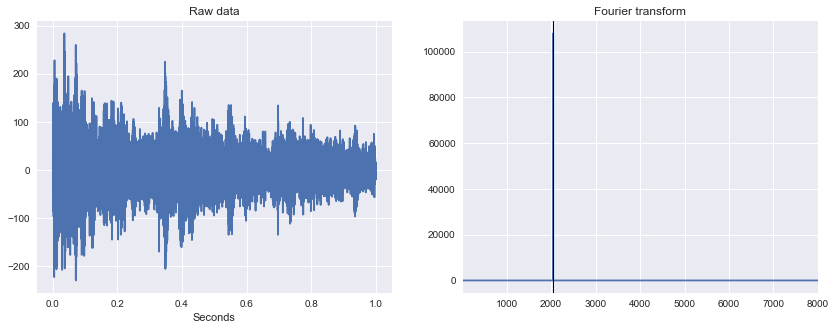

In [76]:
### Configure
stream_config = {
    "chunk": 1024,
    "format": pyaudio.paInt16,
    "channels": 1,
    "rate": 44100
}
fft_config = {
    "noise_cutoff": 100000,
    "range_min": 12,   # c0 is 16.35 Hz
    "range_max": 8000, # b8 is 7902.13 Hz
}
SECONDS = 1
ITERATIONS = 3
plot_config = {
    "seconds": SECONDS,
    "figsize": (14, 5),
}

for _ in range(ITERATIONS):
    data = sample(SECONDS, stream_config)
    plot_sample(data, fft_config, plot_config)